In [1]:
# Cell 1: Import Required Libraries
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
import scipy
import sklearn
import os
from scipy.signal import butter, filtfilt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report



In [2]:
# Cell 2: Load EEG Data
data_folder = r"D:\dataset eeg"

# Get all .npz files in the folder
npz_files = [f for f in os.listdir(data_folder) if f.endswith('.npz')]

# Load all .npz files into a dictionary
eeg_data = {}
for file in npz_files:
    file_path = os.path.join(data_folder, file)
    data = np.load(file_path, allow_pickle=True)
    eeg_data[file] = data

# Print keys of the first file
first_file = npz_files[0]
print(f"Keys in {first_file}: {list(eeg_data[first_file].keys())}")


Keys in eeg-predictive_train.npz: ['train_signals', 'train_labels']


In [3]:
# Cell 3: Merge Training Data
train_signals_1 = eeg_data["eeg-predictive_train.npz"]["train_signals"]
train_labels_1 = eeg_data["eeg-predictive_train.npz"]["train_labels"]

train_signals_2 = eeg_data["eeg-seizure_train.npz"]["train_signals"]
train_labels_2 = eeg_data["eeg-seizure_train.npz"]["train_labels"]

# Merge the datasets
train_signals = np.concatenate((train_signals_1, train_signals_2), axis=0)
train_labels = np.concatenate((train_labels_1, train_labels_2), axis=0)

# Print shape of merged data
print("Merged Train Signals Shape:", train_signals.shape)
print("Merged Train Labels Shape:", train_labels.shape)


Merged Train Signals Shape: (45948, 23, 256)
Merged Train Labels Shape: (45948,)


In [ ]:
#  seizure (1) and non-seizure (0) samples
seizure_indices = np.where(train_labels == 1)[0]
non_seizure_indices = np.where(train_labels == 0)[0]

# Randomly select 5,000 samples from each class
np.random.seed(42) 
seizure_sample = np.random.choice(seizure_indices, 8000, replace=False)
non_seizure_sample = np.random.choice(non_seizure_indices, 8000, replace=False)

# Combine selected samples
selected_indices = np.concatenate((seizure_sample, non_seizure_sample))

# Subset the dataset
train_signals_balanced = train_signals[selected_indices]
train_labels_balanced = train_labels[selected_indices]

# Print new dataset size
print("Balanced Train Signals Shape:", train_signals_balanced.shape)
print("Balanced Train Labels Shape:", train_labels_balanced.shape)

# Check label distribution
unique, counts = np.unique(train_labels_balanced, return_counts=True)
print("New Label Distribution:", dict(zip(unique, counts)))

Balanced Train Signals Shape: (16000, 23, 256)
Balanced Train Labels Shape: (16000,)
New Label Distribution: {0.0: 8000, 1.0: 8000}


In [ ]:
import numpy as np
import scipy.fftpack

mav = np.mean(np.abs(train_signals_balanced), axis=(1, 2))

# Applied Fast Fourier Transform  to get frequency-domain features
fft_features = np.abs(scipy.fftpack.fft(train_signals_balanced, axis=-1))

# Extracted low-frequency power (0–15Hz roughly corresponds to first ~15 bins)
low_freq_power = np.sum(fft_features[:, :, :15], axis=(1, 2))

# Step 3: Define thresholds
mav_severe_thresh = np.percentile(mav, 90)    # Top 10% MAV → Severe
mav_mild_thresh = np.percentile(mav, 50)      # 50–90% MAV → Mild

low_freq_high_thresh = np.percentile(low_freq_power, 80)  # High seizure pattern

# Step 4: Create new labels using hybrid logic
new_labels = []
for i in range(len(mav)):
    if mav[i] >= mav_severe_thresh or low_freq_power[i] >= low_freq_high_thresh:
        new_labels.append(1)  # Severe Epileptic
    elif mav[i] >= mav_mild_thresh:
        new_labels.append(2)  # Mild Epileptic
    else:
        new_labels.append(0)  # Non-Epileptic

train_labels_balanced = np.array(new_labels)

# Step 5: Print updated label distribution
unique, counts = np.unique(train_labels_balanced, return_counts=True)
print("Label Distribution:", dict(zip(unique, counts)))


Label Distribution: {0: 8000, 1: 3319, 2: 4681}


In [7]:
# Normalize EEG signals (Min-Max Scaling)
train_signals_balanced = (train_signals_balanced - np.min(train_signals_balanced)) / (np.max(train_signals_balanced) - np.min(train_signals_balanced))

print("EEG Signals After Normalization:")
print("Min:", np.min(train_signals_balanced), "Max:", np.max(train_signals_balanced))

EEG Signals After Normalization:
Min: 0.0 Max: 1.0


In [8]:
# Bandpass filter function (removes noise outside 0.5–40 Hz)
def bandpass_filter(data, lowcut=0.5, highcut=40.0, fs=256, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=-1)

# Apply bandpass filter to EEG signals
train_signals_filtered = bandpass_filter(train_signals_balanced)

print("EEG Signals After Bandpass Filtering:")
print("Shape:", train_signals_filtered.shape)

EEG Signals After Bandpass Filtering:
Shape: (16000, 23, 256)


In [9]:
from tensorflow.keras.utils import to_categorical

# Convert labels to categorical (one-hot encoding)
train_labels_onehot = to_categorical(train_labels_balanced, num_classes=3)

# Print first 5 samples to check encoding
print("Example of One-Hot Encoded Labels:")
print(train_labels_onehot[:5])

Example of One-Hot Encoded Labels:
[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]]


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import re


#Feature Extraction 

#Convert EEG signals to images
X = train_signals_filtered  # shape: (num_samples, 23, 256)
X_expanded = np.expand_dims(X, axis=-1)  # (num_samples, 23, 256, 1)
X_tiled = np.tile(X_expanded, (1, 1, 1, 3))  # (num_samples, 23, 256, 3)
X_resized = tf.image.resize(X_tiled, (75, 75)).numpy()  # (num_samples, 75, 75, 3)

# Preparing the4  images for InceptionV3
X_preprocessed = preprocess_input(X_resized)

# Load InceptionV3 model and extract features
inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(75, 75, 3))


# Turn features into sequences for LSTM
num_samples = features.shape[0]
seq_length = 8  # Number of time steps
feature_dim = features.shape[1] // seq_length
sequence_features = features.reshape((num_samples, seq_length, feature_dim))
print("Sequence features shape:", sequence_features.shape)  # (num_samples, 8, feature_dim)


#  Hybrid LSTM-Autoencoder model 

# Input for sequences
input_seq = Input(shape=(seq_length, feature_dim), name="input_sequence")

# Encoder: Learn patterns
encoded = LSTM(512, return_sequences=True, name="encoder_lstm1")(input_seq)
encoded = BatchNormalization(name="encoder_bn1")(encoded)
encoded = LSTM(256, return_sequences=False, name="encoder_lstm2")(encoded)
encoded = Dense(128, activation='relu', kernel_regularizer=l2(0.01), name="encoder_dense")(encoded)
encoded = Dropout(0.4, name="encoder_dropout")(encoded)

# Decoder: Rebuild input
repeated = RepeatVector(seq_length, name="repeat_vector")(encoded)
decoded = LSTM(256, return_sequences=True, name="decoder_lstm1")(repeated)
decoded = BatchNormalization(name="decoder_bn1")(decoded)
decoded = LSTM(128, return_sequences=True, name="decoder_lstm2")(decoded)
decoder_output = TimeDistributed(Dense(feature_dim), name="decoder_output")(decoded)

# Classifier: Predict labels
classifier_dense = Dense(64, activation='relu', kernel_regularizer=l2(0.01), name="classifier_dense")(encoded)
classifier_dense = Dropout(0.4, name="classifier_dropout")(classifier_dense)
classification_output = Dense(3, activation='softmax', name="classification_output")(classifier_dense)

# Build model
hybrid_model = Model(inputs=input_seq, outputs=[decoder_output, classification_output])

# Set up training
hybrid_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss={
        'decoder_output': 'mse',  # Error for rebuilding input
        'classification_output': 'categorical_crossentropy'  # Error for labels
    },
    loss_weights={
        'decoder_output': 0.3,  # Less focus on rebuilding
        'classification_output': 1.0  # More focus on labels
    },
    metrics={
        'classification_output': ['accuracy']
    }
)

plain_model_summary(hybrid_model)


# Split data
X_train, X_test, y_train_class, y_test_class = train_test_split(
    sequence_features,
    train_labels_onehot,
    test_size=0.2,
    random_state=42,
    stratify=train_labels_balanced
)

# Stop if no improvement
early_stopping = EarlyStopping(
    monitor='val_classification_output_accuracy',
    patience=7,
    restore_best_weights=True,
    mode='max'
)

# Lower learning rate if stuck
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

# Train
history = hybrid_model.fit(
    X_train,
    {'decoder_output': X_train, 'classification_output': y_train_class},
    epochs=30,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler]
)


# Test results
results = hybrid_model.evaluate(
    X_test,
    {'decoder_output': X_test, 'classification_output': y_test_class}
)
print("Test results (loss, decoder loss, classification loss, classification accuracy):", results)

# Detailed performance
_, class_preds = hybrid_model.predict(X_test)
y_pred_classes = np.argmax(class_preds, axis=1)
y_true_classes = np.argmax(y_test_class, axis=1)

precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-Score: {f1:.4f}")

500/500 ━━━━━━━━━━━━━━━━━━━━ 47s 88ms/step
Extracted features shape: (16000, 2048)
Sequence features shape: (16000, 8, 256)


Model: "functional_4"
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_sequence      │ (None, 8, 256)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm1       │ (None, 8, 512)    │  1,574,912 │ input_sequence[0… │
│ (LSTM)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_bn1         │ (None, 8, 512)    │      2,048 │ encoder_lstm1[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm2       │ (None, 256)       │    787,456

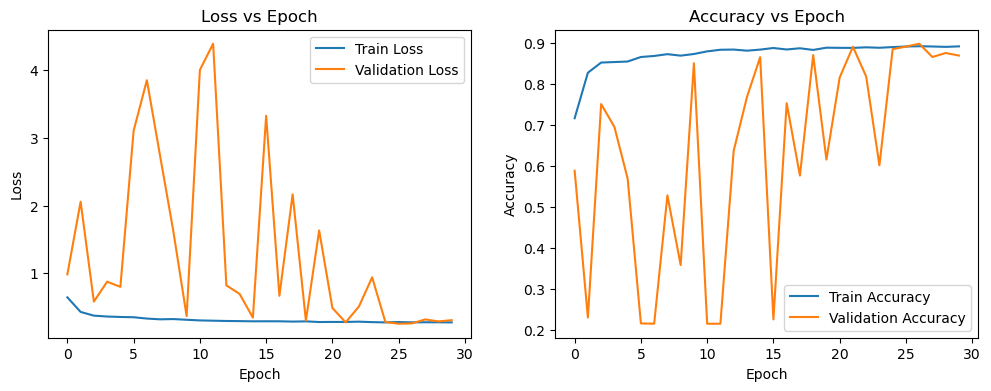

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot Loss vs Epoch
plt.subplot(1, 2, 1)
plt.plot(history.history['classification_output_loss'], label='Train Loss')
plt.plot(history.history['val_classification_output_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epoch')

# Plot Accuracy vs Epoch
plt.subplot(1, 2, 2)
plt.plot(history.history['classification_output_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_classification_output_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Epoch')

plt.show()



In [ ]:
from sklearn.metrics import classification_report, f1_score

# Generate the classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=['Class 0', 'Class 1', 'Class 2'])

# Print the classification report
print("Classification Report:\n", report)

# Compute the overall F1-score
f1_macro = f1_score(y_true_classes, y_pred_classes, average='macro')
f1_micro = f1_score(y_true_classes, y_pred_classes, average='micro')
f1_weighted = f1_score(y_true_classes, y_pred_classes, average='weighted')




Classification Report:
               precision    recall  f1-score   support

     Class 0       0.91      0.98      0.94      1600
     Class 1       0.95      0.85      0.90       664
     Class 2       0.85      0.80      0.82       936

    accuracy                           0.90      3200
   macro avg       0.90      0.88      0.89      3200
weighted avg       0.90      0.90      0.90      3200



100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


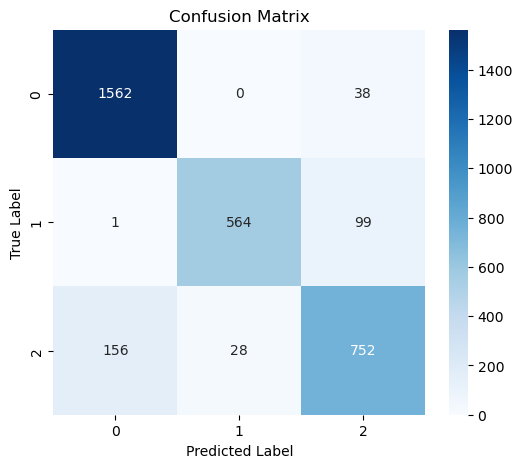

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get classification predictions
_, class_preds = hybrid_model.predict(X_test)
y_pred_classes = np.argmax(class_preds, axis=1)
y_true_classes = np.argmax(y_test_class, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


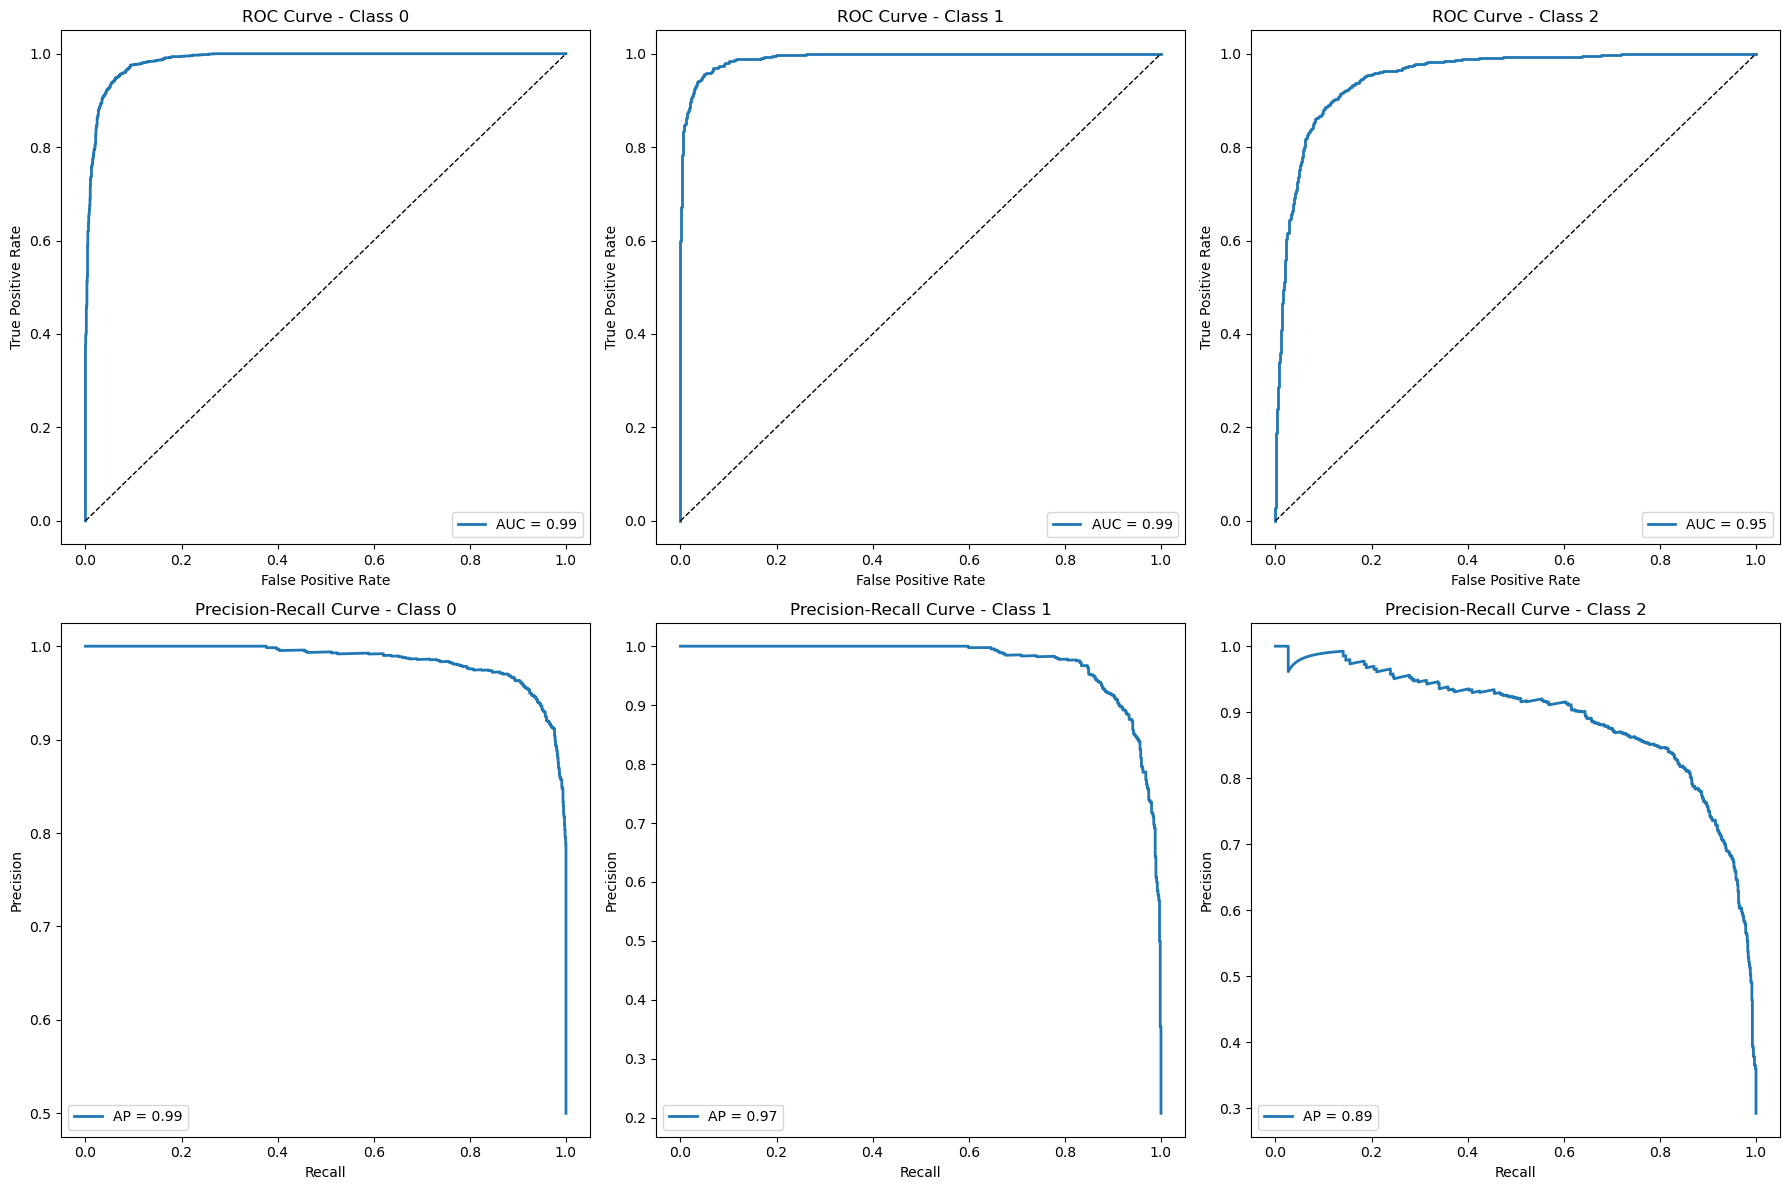

In [19]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Compute ROC and PR curves for each class
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for i in range(3):  # Iterate over each class (0, 1, 2)
    # Compute ROC Curve
    fpr, tpr, _ = roc_curve(y_test_class[:, i], class_preds[:, i])
    roc_auc = auc(fpr, tpr)
    
    axes[0, i].plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', linewidth=2)
    axes[0, i].plot([0, 1], [0, 1], 'k--', linewidth=1)  # Diagonal reference line
    axes[0, i].set_xlabel("False Positive Rate")
    axes[0, i].set_ylabel("True Positive Rate")
    axes[0, i].set_title(f"ROC Curve - Class {i}")
    axes[0, i].legend(loc="lower right")
    
    # Compute Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test_class[:, i], class_preds[:, i])
    ap_score = average_precision_score(y_test_class[:, i], class_preds[:, i])  # Compute AP score
    
    axes[1, i].plot(recall, precision, label=f'AP = {ap_score:.2f}', linewidth=2)
    axes[1, i].set_xlabel("Recall")
    axes[1, i].set_ylabel("Precision")
    axes[1, i].set_title(f"Precision-Recall Curve - Class {i}")
    axes[1, i].legend(loc="lower left")

plt.tight_layout()
plt.show()
